# Natural Language Processsing (NLP) Basics:
This notebook attempts to take a short novel, $\underline{Alice In Wonderland}$ by Lewis Carrol, break it into pieces, vectorize it, 
and cluster it back into the original chapters. 

A book is not an ideal case study to see how good K Means clustering can be. In fact this project points out the
difficulties often associated with this kind of task. NLP is never easy and unsupervised "learning" is about the hardest task in ML.

This notebook provides ample opportunities to play with the data. We will try many things, see what happends, learn about the data set and get a decent start at clustering. One red flag that you'll notice, is that the K means clustering tool, doesn't cluster the documents the same way everytime. That is indicative of a poorly conditioned
data set. Ideally, K Means converges to about the same clustering each time.

For the sake of checking my code and trying different preprocessing ideas, I've set the seeds to alogithmns to allow comparison. 

## Get the Corpus and separate it into Chapter Files
### Project Gutenberg provides the corpus to the book.

I use Linux shell scripting to aid my in my work. Python is great and it's fully object oriented. You'll want to use Python for production quality work. However, if you're trying to get started, and you need some shortcuts, command line tools are an appropriate place to look. Check this out: http://datascienceatthecommandline.com/

One could use Drake, to have a "make file" of these shell composed steps.
http://blog.factual.com/introducing-drake-a-kind-of-make-for-data

In [210]:
%%bash
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

curl -s http://www.gutenberg.org/cache/epub/28885/pg28885.txt > ${data_dir}/alice.txt

In [211]:
%%bash
# the magic "%%bash" doesn't remember the shell parameter
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

# grep to find chapter start lines
grep -in "chapter" ${data_dir}/alice.txt

212:CHAPTER I
422:CHAPTER II
632:CHAPTER III
891:CHAPTER IV
1160:CHAPTER V
1461:CHAPTER VI
1792:CHAPTER VII
2137:CHAPTER VIII
2454:CHAPTER IX
2778:CHAPTER X
3077:CHAPTER XI
3343:CHAPTER XII


In [250]:
%%bash
# the magic "%%bash" doesn't remember the shell parameter
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

# parse out the line number, cut has option "-d" for delimiter, "-f1" selects from "field 1"
grep -in "chapter" ${data_dir}/alice.txt | cut -d: -f1

212
422
632
891
1160
1461
1792
2137
2454
2778
3077
3343


In [213]:
%%bash
# the magic "%%bash" doesn't remember the shell parameter
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

# all together
grep -in "chapter" ${data_dir}/alice.txt | cut -d: -f1 > ${data_dir}/alice_chap_nums.txt
# don't forget the end of the book
grep -in "the end" ${data_dir}/alice.txt | tail -n 1 | cut -d: -f1 >> ${data_dir}/alice_chap_nums.txt

cat ${data_dir}/alice_chap_nums.txt

212
422
632
891
1160
1461
1792
2137
2454
2778
3077
3343
3637


### ZSH is a great shell, better than BASH  IMHO. I like to practice my shell scripting and wrote these lines below as practice using zsh's array syntax. 

In [214]:
# zsh method for creating the chapter files

#array=$("{$(@f)$(<$data_dir/alice_chap_nums.txt)}")

#n=${#array[@]}

#for i in {1..$n};do
#    start=$array[i]
#    next=$(($i+1))
#    end=$(($array[$next])-1))
#    
#    fname=$(print "chap_%02i.txt" $i)
#    sed -n "$start,${end}p" ${data_dir}/alice.txt > $fname

### Same thing in Python
In fact, I prefer using the np.loadtxt method for making a nicely indexed and vectorized array.
ZSH or BASH is a pain to use more than once.

# Unicode

## Python 2, treats text as ascii. That's not ideal.
I suppose I could start using Python 3 more. The fact is I'm still working on that. So, for now,
I'm using the work around of loading the text in as unicode. Sci-kit Learn understands unicode too.

In [215]:
import numpy as np
from os import path
import codecs

data_dir = "/home/daniel/git/Python2.7/DataScience/nlp_training_data"

chap_line_nums = np.loadtxt(path.join(data_dir, 'alice_chap_nums.txt'), dtype='int', delimiter='\n')

f = codecs.open(path.join(data_dir,'alice.txt'), 'r', encoding='utf-8')
lines = f.readlines()
f.close()
     
print chap_line_nums

[ 212  422  632  891 1160 1461 1792 2137 2454 2778 3077 3343 3637]


## Parse into sentences and join them into chunks, that I'll refer to as "docs" collectively for a chapter, and a "doc" for a single chunk from a single chapter.

In [216]:
for i in range(chap_line_nums.size - 1):
    chap_num = i + 1
    f = codecs.open(path.join(data_dir,'chap_%02i.txt' %chap_num), 'w', encoding='utf-8')
    
    start = chap_line_nums[i]
    end = chap_line_nums[i+1] - 1

    for line in lines[start:end]:
        f.write(line) 
    
    f.close()
    

## We'll need to access the path to each chapter file several times.
The glob package allows for simple use of Linux style name globbing. It's important to remember that globbing doesn't use the same syntax as regular expressions.

In [217]:
import glob

chps = glob.glob(path.join(data_dir,"chap_*.txt"))
chps.sort()

for ch in chps:
    print ch

/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_01.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_02.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_03.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_04.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_05.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_06.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_07.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_08.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_09.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_10.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_11.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_12.txt


# NLP
### Helper Functions for my own naive text pre-processing

In [218]:
from nltk import tokenize, stem
import nltk
import re
import numpy as np

class PreProcess(object):
    """Methods to preprocess a corpus for NLP"""
    
    def __init__(self, num_letters=2, num_sent_join=6):
        self.pat = "^[NV]" # "^[NVJR]"
        self.reg = re.compile(self.pat)
        self.stem_obj = stem.SnowballStemmer('english')
        self.num_letters = num_letters
        self.num_sent_join= num_sent_join

    def _get_chap_sents(self, filename):
        """Opens a file as unicode object and tokenized into sentences."""
        f = codecs.open(filename, 'r', encoding='utf-8')
        lines = f.read()
        f.close()

        sents = tokenize.sent_tokenize(lines)
        sents = map(lambda s:s.replace('\r\n',' '), sents)
        sents = map(lambda s:s.replace('_',''), sents)
        sents = map(lambda s:s.replace(',',' '), sents)

        return sents

    def _join_n_sentences(self, sentences):
        """Joins sentences into a single string chunk."""
        new_lines = []
        num_sent = len(sentences)
        index = np.arange(0, num_sent, self.num_sent_join)

        for i in index:
            concat_lines = ' '.join(sentences[i:i+n+1])
            new_lines.append(concat_lines)

        return new_lines    

    def build_docs(self, filename):
        """Opens a file, tokenized into sentences, then joins sentences
        into a single string chunk."""
        
        sents = self._get_chap_sents(filename)
        doc = self._join_n_sentences(sents)

        return doc

    def _get_nltk_pos(self, string):
        """Takes a string, tokenizes into words, then gets the nltk
        part of speech tags."""
        
        string = tokenize.word_tokenize(string)
        pos = nltk.pos_tag(string)

        return pos

    def _filter_pos(self, pos):
        """Filters out pos tags according to self.pat"""
        
        out = []
        for item in pos:
            if self.reg.match(item[1]):
                out.append(item[0])

        return out        

    def get_pos(self, doc):
        """Returns parts of speech from the document string
        accords to self.pat"""
        
        out = []
        for string in doc:
            pos = self._get_nltk_pos(string)
            temp = self._filter_pos(pos)
            string = ' '.join(temp)
            out.append(string)

        #out = [item for sub_list in out for item in sub_list]
        return out

    def remove_short_words(self, string):
        """Tokenizes a string into words, then removes words whose
        num of char is less than self.num_letters"""
        
        out = []
        for word in tokenize.word_tokenize(string):
            if len(word) <= self.num_letters:
                continue
            else:
                out.append(word)

        return ' '.join(out)    

    def stemmer(self, doc):
        """Takes a string doc, tokenizes into words, then uses the 
        nltk stemmer"""
        
        words = tokenize.word_tokenize(doc)
        stems = map(self.stem_obj.stem, words)
        new_doc = " ".join(stems)

        return new_doc
    
    def preprocess_docs(self, docs):
        """Takes a list of single string 'docs', and removes the short
        words according to self.num_letters, runs nltk stemmer, and filters
        for parts of speech according to self.pat."""
        
        docs = map(self.remove_short_words, docs)
        docs = map(self.stemmer, docs)
        docs = self.get_pos(docs)
        
        return docs
        

# Borrowed Grammar Code from Gist
### For more advanced text pre-processing
#### Borrowed with slight modifications from:  https://gist.github.com/alexbowe/879414#file-nltk-intro-py-L34

In [251]:
# https://gist.github.com/alexbowe/879414#file-nltk-intro-py-L34
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer_alt = nltk.stem.porter.PorterStemmer()

# Used when tokenizing words
sentence_re = r'''(?x)      # set flag to allow verbose regexps
      ([A-Z])(\.[A-Z])+\.?  # abbreviations, e.g. U.S.A.
    | \w+(-\w+)*            # words with optional internal hyphens
    | \$?\d+(\.\d+)?%?      # currency and percentages, e.g. $12.40, 82%
    | \.\.\.                # ellipsis
    | [][.,;"'?():-_`]      # these are separate tokens
'''
# This grammar is from: S. N. Kim, T. Baldwin, and M.-Y. Kan. 
# Evaluating n-gram based evaluation metrics for automatic keyphrase extraction. 
# Technical report, University of Melbourne, Melbourne 2010.

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns

    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""


class Alternate(object):
    """Fancier preprocessing of corpus using a grammar."""
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter=lambda t:t.label() == 'NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        word = stemmer_alt.stem_word(word)
        word = lemmatizer.lemmatize(word)
        
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword."""
        accepted = bool(2 <= len(word) <= 20
            and word.lower() not in stopwords)
        
        return accepted

    def get_terms(self, tree):
        """Filters the main tree and it's subtrees for 'leaves', normalizes the
        words in the leaves and returns a generator."""
        
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,_ in leaf if self.acceptable_word(w) ]
            
            yield term
            
    def get_words(self, terms):
        """Loops over the terms and returns a single string of the words."""
        
        out = []
        for term in terms:
            for word in term:
                out.append(word)
        
        return " ".join(out)
            
    def main(self, text):
        """Breaks a single string into a tree using the grammar and returns
        the specified words as a string."""
        
        chunker = nltk.RegexpParser(grammar)

        toks = nltk.regexp_tokenize(text, sentence_re)
        postoks = nltk.tag.pos_tag(toks)

        #print postoks
        tree = chunker.parse(postoks)

        terms = self.get_terms(tree)
        
        words = self.get_words(terms)

        return words

# Comparison of Grammar Method and My Own Preprocessing

In [220]:
preprocess = PreProcess()
docs = preprocess.build_docs(chps[0])

print docs[3] 

Would the fall never come to an end? "I wonder how many miles I've fallen by this time?" she said aloud. "I must be getting somewhere near the centre of the earth. Let me see: that would be four thousand miles down. I think--" (for  you see  Alice had learnt several things of this sort in her lessons in the schoolroom  and though this was not a very good opportunity for showing off her knowledge  as there was no one to listen to her  still it was good practice to say it over) "--yes  that's about the right distance--but then I wonder what Latitude or Longitude I've got to?" (Alice had no idea what Latitude was  or Longitude either  but thought they were nice grand words to say.) Presently she began again. "I wonder if I shall fall right through the earth! How funny it'll seem to come out among the people that walk with their heads downwards! The Antipathies  I think--" (she was rather glad there was no one listening  this time  as it didn't sound at all the right word) "--but I shall h

In [221]:
docs = map(preprocess.remove_short_words, docs)
docs = map(preprocess.stemmer, docs)
print docs[3]

would the fall never come end wonder how mani mile ve fallen this time she said aloud must get somewher near the centr the earth let see that would four thousand mile down think for you see alic had learnt sever thing this sort her lesson the schoolroom and though this was not veri good opportun for show off her knowledg there was one listen her still was good practic say over yes that about the right distanc but then wonder what latitud longitud ve got alic had idea what latitud was longitud either but thought they were nice grand word say present she began again wonder shall fall right through the earth how funni ll seem come out among the peopl that walk with their head downward the antipathi think she was rather glad there was one listen this time did n't sound all the right word but shall have ask them what the name the countri you know pleas ma'am this new zealand australia and she tri curtsey she spoke fanci curtsey you re fall through the air you think you could manag and what 

###  Add POS tags, taking only Nouns and Verbs

In [222]:
docs = preprocess.get_pos(docs)
print docs[3]

fall come end wonder mani mile ve fallen time said must get centr earth let see four thousand mile think see had learnt thing sort lesson schoolroom was veri opportun show knowledg was listen was say yes right distanc latitud longitud ve got had idea latitud was longitud thought were grand word say present began wonder fall funni ll seem come peopl walk head downward antipathi think was glad was listen time did sound right word have ask name countri know pleas zealand australia tri curtsey spoke fanci curtsey re fall air think manag ignor littl girl think ll ask perhap see written somewher was els soon began talk ll miss veri think dinah was cat hope ll rememb saucer milk tea-tim


## Alternate Grammar Example

In [223]:
alt = Alternate()
docs = preprocess.build_docs(chps[0])
docs = map(alt.main, docs)
print docs[3]

fall end mani mile time centr let thousand mile alic sever thing sort lesson schoolroom good opportun show knowledg one good practic ye right distanc latitud longitud ve got alic idea latitud longitud nice grand word earth ll peopl walk head downward antipathi one time right word name countri plea ma new zealand australia fanci curtsey re air ignor littl girl ll ll noth alic dinah ll miss dinah cat ll rememb saucer milk


# Build the Full Demo

In [224]:
import pandas as pd
df = pd.DataFrame()

for ind, file_ in enumerate(chps, start=1):
    docs = preprocess.build_docs(file_)
    
    ### choose between preprocessing methods ###
    docs = map(alt.main, docs)
    #docs = preprocess.preprocess_docs(docs)

    n = len(docs)
    temp = pd.DataFrame({ 'doc':docs, 'chap':np.ones(n)*ind })
    df = pd.concat([df, temp], axis=0)

In [225]:
df.sample(n=10, replace=False, weights=None, random_state=1, axis=None)

,chap,doc
19,12,littl sister after-tim grown woman year heart ...
8,5,ll kick stair caterpillar alic word begin cate...
15,5,pigeon serpent alic let serpent pigeon tone ki...
1,12,much use trial way juri shock slate pencil his...
12,1,fanci flame candl candl thing find noth poor a...
15,11,king come finish guinea-pig alic tea hatter an...
17,6,alic matter way cat alic explan oh re sure cat...
11,1,curiou feel alic telescop inch face thought ri...
5,5,caterpillar alic noth someth worth hear minut ...
9,6,oh plea mind re alic jump agoni terror oh prec...


# Feature Extraction / Vectorization

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

## TF-IDF
TF-IDF is helpful here b/c we do want to reduce the weight of words that occur
often. However, You'll notice that I removed the short words from the "docs". That usually isn't necessary if the
corpus is composed of sinlge sentences or tweets. But here, I built up the docs from a joining of sentences. Thus, the high frequency words wouldn't be discovered as such, since each document is large.

I choose the maximum and minimum document frequency with care. I often use the ration form of the argument, such as 0.65 and 0.001. Again, since the documents are composed of multiple sentences, I decided against that. Examining the counts below gives us some clues as to good numbers to pick.

You should try your own numbers.

In [227]:
grp = df.groupby('chap')
cnts = grp.chap.count()
_sum = grp.chap.count().sum()
mu = grp.chap.count().mean()

print cnts, "\n total", _sum, "\n mean", mu

chap
1     15
2     20
3     20
4     25
5     23
6     25
7     30
8     24
9     28
10    26
11    21
12    20
Name: chap, dtype: int64 
 total 277 
 mean 23.0833333333


 ## Stop Words are words which are exluded. We should like to keep these words for the grammar building since they add structure, but here they are likely to correlate too often to be useful.

In [228]:
additional_stop_words = ['chapter', 'illustration', 'alice', 'sidenote']
# don't forget to run the stemmer on the additional stop words
additional_stop_words = map(preprocess.stem_obj.stem, additional_stop_words)
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)
print additional_stop_words

[u'chapter', u'illustr', u'alic', u'sidenot']


In [229]:
min_df = cnts.min() - 3
max_df = np.floor(cnts.mean() * 3)

In [230]:
vectorizer = TfidfVectorizer(max_features=150,
                             lowercase=True,
                             max_df=max_df,
                             min_df=min_df,
                             use_idf=True,
                             stop_words=stop_words,
                             norm='l2',
                             ngram_range=(1, 2),
                             analyzer='word',
                             decode_error='ignore',
                             strip_accents='unicode'
                            )

In [252]:
matrix = vectorizer.fit_transform(df['doc'])
features = vectorizer.get_feature_names()      

print matrix.shape 
print features

(277, 150)
[u'air', u'anyth', u'arm', u'babi', u'beauti', u'begin', u'bird', u'bit', u'book', u'bottl', u'busi', u'cat', u'caterpillar', u'chang', u'child', u'close', u'come', u'confus', u'convers', u'cook', u'cours', u'court', u'creatur', u'curiou', u'danc', u'day', u'deal', u'dear', u'dinah', u'door', u'dormous', u'duchess', u'ear', u'end', u'everybodi', u'everyth', u'eye', u'face', u'fact', u'foot', u'game', u'garden', u'glass', u'glove', u'good', u'great', u'gryphon', u'half', u'hand', u'hare', u'hatter', u'head', u'heart', u'hedgehog', u'hous', u'hurri', u'idea', u'juri', u'king', u'knave', u'larg', u'leav', u'lesson', u'let', u'life', u'littl', u'll', u'lobster', u'long', u'look', u'low', u'mad', u'majesti', u'mani', u'march', u'march hare', u'matter', u'mean', u'mind', u'minut', u'mock', u'mock turtl', u'moment', u'mous', u'mouth', u'mushroom', u'nobodi', u'nose', u'noth', u'oh', u'old', u'opportun', u'parti', u'peopl', u'piec', u'pig', u'place', u'plea', u'poor', u'queen', u'qu

In [232]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from sklearn.cluster import KMeans
from sklearn import metrics

## Cosine Similarity is a fancy way of talking about a correlational, or dot product relationship.

Recall that an dot product between vectors is a scalar and is defined:


$$    \mathbf A \cdot \mathbf B = \left\| \mathbf A \right\| \, \left\| \mathbf B \right\| \cos \theta $$

In [233]:
cos_sim = cosine_similarity(matrix)
cos_sim.shape

(277, 277)

## We'd like to see clusters about the diagonal
Bright spots away from the diagonal mean that a "document", or chunk
of sentences, are correlating with a chunk from far away.

<matplotlib.colorbar.Colorbar instance at 0x7f29043ed710>

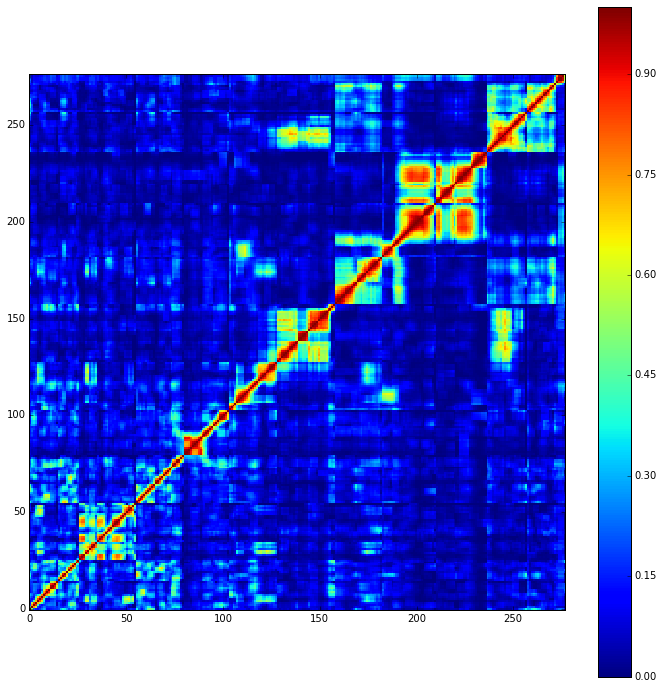

In [234]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.imshow(cos_sim, origin='lower', interpolation='nearest')
plt.colorbar()

## K means operates on a distance metric.
Sometimes it's useful to use the "cosine" distance.

### $\text{cosine distance} = 1 - \text{cosine similarity}$

Cosine Similarity of two vectors is the relative projection of each vector onto every other vector. It's an "outer product", where the dimensions are increased, rather than an inner product where the dimensions are collasped.

In [235]:
cos_dist = cosine_distances(matrix)
euc_dist = euclidean_distances(matrix)

In [236]:
# Here I use the Euclidean Distance but you can try the Cosine 
k = len(chps)
km = KMeans(k,
            init='random',
            #init='k-means++', 
            n_init=100, 
            max_iter=1000, 
            tol=1e-7, 
            precompute_distances=True, 
            verbose=0, 
            random_state=1, 
            copy_x=True,
            n_jobs=4
            )

assignments = km.fit_predict(euc_dist)
print np.unique(assignments)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [237]:
df['cluster_chaps'] = assignments + 1

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score

Homogeneity metric of a cluster labeling given a ground truth
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [238]:
metrics.homogeneity_score(df.chap, df.cluster_chaps)

0.61484529063160276

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score

Completeness metric of a cluster labeling given a ground truth
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [239]:
metrics.completeness_score(df.chap, df.cluster_chaps)

0.68659911360053605

## Visualise the distributions of the learned clusters
Here I use Histograms to visualize the amount of overlap between the 
learned clusters. Ideally, I'd want to see one bin per document. But I'd settle for one large peak in a bin, where the others where short. 

chap
1     [[Axes(0.125,0.125;0.775x0.775)]]
2     [[Axes(0.125,0.125;0.775x0.775)]]
3     [[Axes(0.125,0.125;0.775x0.775)]]
4     [[Axes(0.125,0.125;0.775x0.775)]]
5     [[Axes(0.125,0.125;0.775x0.775)]]
6     [[Axes(0.125,0.125;0.775x0.775)]]
7     [[Axes(0.125,0.125;0.775x0.775)]]
8     [[Axes(0.125,0.125;0.775x0.775)]]
9     [[Axes(0.125,0.125;0.775x0.775)]]
10    [[Axes(0.125,0.125;0.775x0.775)]]
11    [[Axes(0.125,0.125;0.775x0.775)]]
12    [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

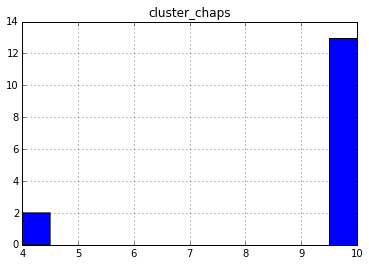

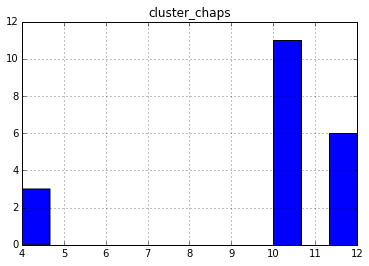

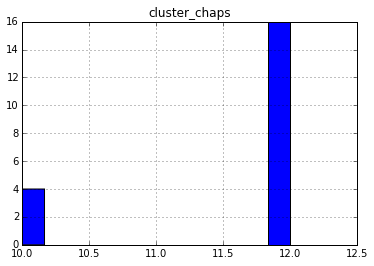

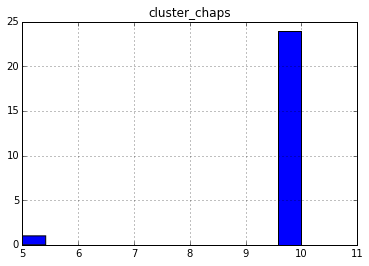

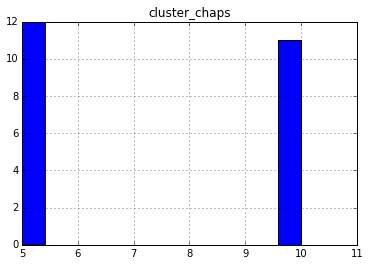

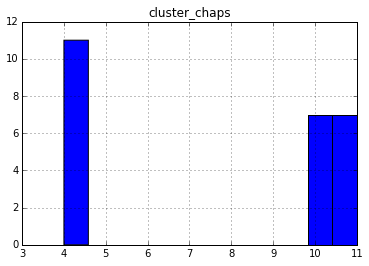

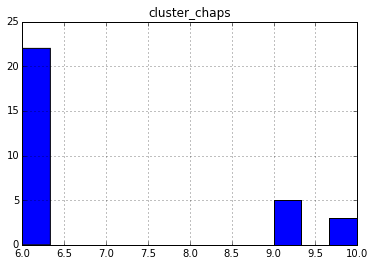

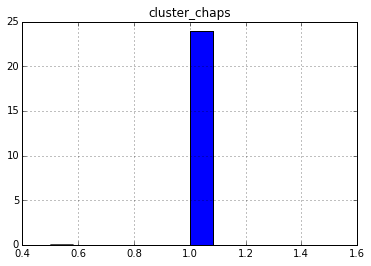

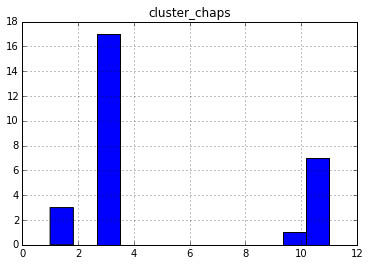

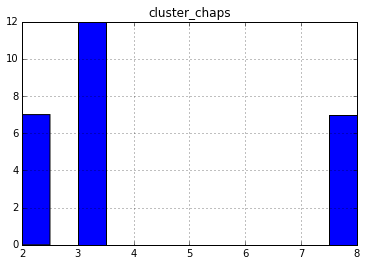

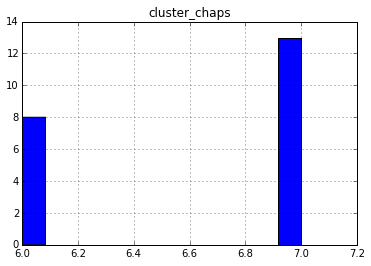

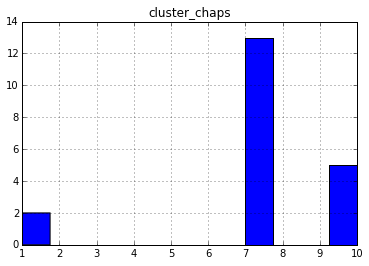

In [240]:
%matplotlib inline
grp = df.groupby('chap')
grp.hist(bins=k)

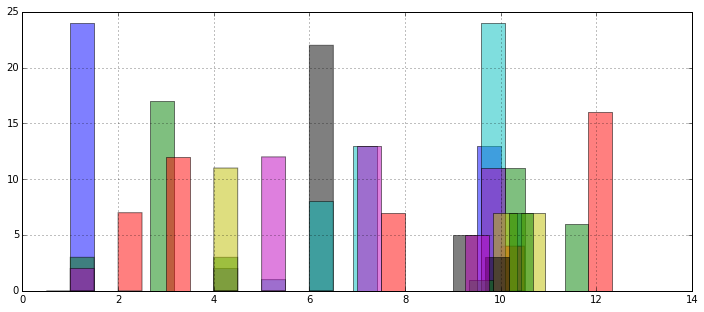

In [241]:
for i in range(1, k+1):
    df[df.chap == i]['cluster_chaps'].hist(figsize=(12,5), alpha=0.5, width=0.5, bins=k)

## Supervised Learning, Just for Fun

In [291]:
from sklearn.cross_validation import train_test_split
X = matrix
y = df.chap

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=12)
y = np.ravel(y)

In [292]:
print X_train.shape, X_test.shape

(263, 150) (14, 150)


In [293]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

clf = RandomForestClassifier(n_estimators=10, 
                             criterion='gini', 
                             max_depth=8, 
                             random_state=1
                            )
                            
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print "Accuracy:", metrics.accuracy_score(y_test, y_pred)

Accuracy: 1.0


## Confusion Matrix

I think of a confusion matrix as the covariance matrix, with the
predicted outcomes along the rows, and the true labels along the columns.

In [294]:
def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    error_rate = (y_pred != y_test).mean()
    
    return cm

(9, 9)


<matplotlib.colorbar.Colorbar instance at 0x7f28fafbabd8>

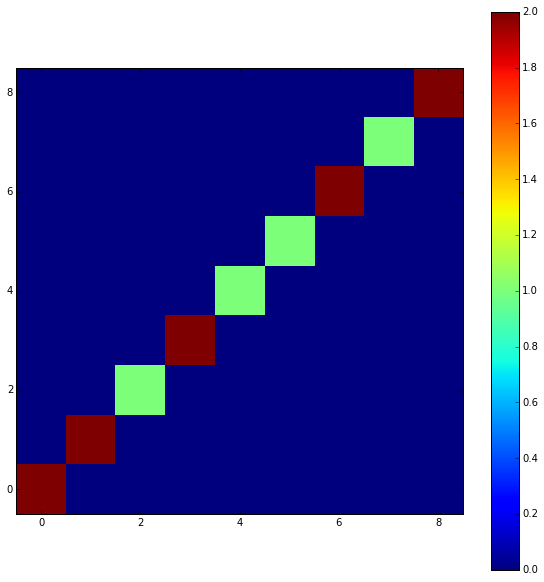

In [295]:
cm = confusion_matrix(y_test, y_pred)
print cm.shape
plt.figure(figsize=(10, 10))
plt.imshow(cm, origin='lower', interpolation='nearest')
plt.colorbar()

## Feature Analysis

Random Forest has the nice attribute that is returns the "important" features.

In [296]:
importances = clf.feature_importances_
print "Num of import vectors:", importances.size
indices = np.argsort(importances)[0:5]

inverse_features = vectorizer.inverse_transform(matrix)
print "Num of feature vectors", len(inverse_features)

Num of import vectors: 150
Num of feature vectors 277


In [297]:
for i in range(indices.size):
    string = "Rank %(rank)i:\n %(features)s\n"
    words = ", ".join(inverse_features[indices[i]])
    string = string %{"rank":i+1,
                     "features":words
                     }
    print string

Rank 1:
 soup, cook, babi, pig, remark, tone, everyth, talk, duchess, fact, larg, door, cat, air, plea, word, opportun, good, thing, end, anyth, moment, oh, day, use, convers

Rank 2:
 reason, arm, till, someth, voic, sure, come, size, glass, round, door, hand, air, sort, hous, ll, anyth, rabbit

Rank 3:
 vers, soup, cook, babi, nose, busi, remark, everybodi, tone, everyth, talk, duchess, deal, fact, child, larg, poor, round, close, littl, plea, head, word, opportun, sort, thing, end, oh, day, mind, convers

Rank 4:
 place, slate, till, old, confus, silenc, everyth, voic, deal, sure, close, littl, head, word, ve, good, sort, thing, mani, ll, anyth, foot, time, oh, mind, rabbit

Rank 5:
 someth, sea, everyth, queer, sure, life, tear, thought, child, rate, mous, word, idea, right, thing, hous, moment, foot, way, day, use

